In [93]:
model_save_path = "saved_model_lstm1"
# cols = ["KOSPI", "KOSPI_START", "KOSPI_HIGH", "KOSPI_LOW", "NASDAQ", "DOW", "CR", "GOLD"]
cols = ["KOSPI", "KOSPI_START", "KOSPI_HIGH", "KOSPI_LOW"]
len_x_ARMA = 60
len_y_nextday = 1
scale_method = "minmax"

In [94]:
from kospi_predict import Crawler

crawler = Crawler(crawl_page_max=30, perPage=100)
# crawler.crawlData(cols, save=True)
crawler.loadFromSavedFile(cols)
df_crawled = crawler.removeNan()
df_crawled = df_crawled.loc[:2000]
df_crawled

,date,KOSPI,KOSPI_START,KOSPI_HIGH,KOSPI_LOW
0,2022-04-08,2700.39,2706.64,2712.00,2685.52
1,2022-04-07,2695.86,2714.70,2718.50,2693.36
2,2022-04-06,2735.03,2739.07,2747.85,2730.66
3,2022-04-05,2759.20,2765.50,2769.18,2750.50
4,2022-04-04,2757.90,2729.86,2758.38,2722.45
...,...,...,...,...,...
1996,2014-02-25,1964.86,1958.30,1964.86,1955.70
1997,2014-02-24,1949.05,1958.06,1961.41,1943.86
1998,2014-02-21,1957.83,1948.03,1957.83,1946.68
1999,2014-02-20,1930.57,1932.90,1941.13,1927.53


In [95]:
from kospi_predict import DataPreprocessor
from sklearn.preprocessing import MinMaxScaler as MinMaxScaler

dpp = DataPreprocessor(df_crawled, cols, scale_method, model_save_path)
dpp.sortByDate()
# dpp.makeDiffByRange(1, len_x_ARMA)
# dpp.makeDiffRatio()
# dpp.makeAR(0, len_x_ARMA)
# dpp.makeMA(2, len_x_ARMA)
dpp.makeTargetYs(len_y_nextday)
dpp.cutoffData(len_x_ARMA, len_y_nextday)

In [96]:
# df = dpp.df[500:1500]
# df.reset_index(drop=True, inplace=True)
dpp.df

,date,KOSPI,KOSPI_START,KOSPI_HIGH,KOSPI_LOW,Y_KOSPI_nextday_1
0,2014-05-20,2011.26,2011.85,2014.46,2004.32,2008.33
1,2014-05-21,2008.33,2003.48,2015.63,2001.74,2015.59
2,2014-05-22,2015.59,2015.41,2022.59,2011.60,2017.17
3,2014-05-23,2017.17,2013.09,2017.96,2011.76,2010.35
4,2014-05-26,2010.35,2016.21,2020.96,2008.14,1997.63
...,...,...,...,...,...,...
1934,2022-04-01,2739.85,2745.85,2745.85,2729.68,2757.90
1935,2022-04-04,2757.90,2729.86,2758.38,2722.45,2759.20
1936,2022-04-05,2759.20,2765.50,2769.18,2750.50,2735.03
1937,2022-04-06,2735.03,2739.07,2747.85,2730.66,2695.86


In [104]:
import numpy as np
import pandas as pd

def rescalingByMinMax(arr):
    if len(arr.shape) > 1:
        for col_idx in range(arr.shape[1]):
            this_arr = arr[:, col_idx]
            max_val = max(this_arr)
            min_val = min(this_arr)
            for row_idx, val in enumerate(this_arr):
                new_val = (val - min_val) / (max_val - min_val)
                arr[row_idx, col_idx] = new_val
    else:
        max_val = max(arr)
        min_val = min(arr)
        for row_idx, val in enumerate(arr):
            new_val = (val - min_val) / (max_val - min_val)
            arr[row_idx] = new_val
    return arr

def makeWindow(df, row_cnt = 20):
    mat_list = []
    date_list = []
    y_list = []
    for idx in range(len(df)):
        if idx > row_cnt:
            this_mat = rescalingByMinMax(np.array(df.iloc[idx-row_cnt:idx, 1:len(cols)+1], dtype=np.float32))
            this_mat = np.array(df.iloc[idx-row_cnt:idx, 1:len(cols)+1], dtype=np.float32)
            # this_mat = this_mat.transpose()
            mat_list.append(this_mat)

            #날짜 리스트 입력
            date_list.append(df.iloc[idx, 0])

            #y_list 입력
            y_list.append(df.iloc[idx, -1])

    print(max(y_list), min(y_list))

    mat_list = np.array(mat_list[:-1])
    date_list = np.array(date_list[:-1])
    # y_list = rescalingByMinMax(np.array(y_list[:-1]))
    y_list = np.array(y_list[:-1])

    return mat_list, date_list, y_list

mat_list, date_list, y_list = makeWindow(dpp.df, row_cnt=100)
mat_list.shape, date_list.shape, y_list.shape

3305.21 1457.64


((1837, 100, 4), (1837,), (1837,))

In [105]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(mat_list[:-1], y_list[:-1], test_size=0.2, shuffle=False, random_state=8699)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1468, 100, 4), (368, 100, 4), (1468,), (368,))

In [108]:
import tensorflow as tf

# model = tf.keras.Sequential([
#   tf.keras.layers.Input(x_train.shape[1:]),
#   tf.keras.layers.LSTM(units=20, return_sequences=False, dropout=0.5),
#   tf.keras.layers.Dense(1, activation="sigmoid")
# ])

model = tf.keras.Sequential([
  tf.keras.layers.Input(x_train.shape[1:]),
  # tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(units=128, activation="relu"),
  # tf.keras.layers.Dropout(rate=0.5),
  tf.keras.layers.Dense(units=128, activation="relu"),
  tf.keras.layers.Dense(units=128, activation="relu"),
  tf.keras.layers.Dense(units=128, activation="relu"),
  tf.keras.layers.Dense(units=128, activation="relu"),
  tf.keras.layers.Dense(units=128, activation="relu"),
  tf.keras.layers.Dense(units=128, activation="relu"),
  tf.keras.layers.Dense(units=128, activation="relu"),
  tf.keras.layers.Dense(1, activation="relu")
])


model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss="mse", 
              metrics=["mae", "mse"])

model.summary()

epochs=500
history = model.fit(
  x_train,
  y_train,
  epochs=epochs,
  batch_size = 32,
  validation_split = 0.2,
  verbose = 1
)

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_13 (Flatten)        (None, 400)               0         
                                                                 
 dense_80 (Dense)            (None, 128)               51328     
                                                                 
 dense_81 (Dense)            (None, 128)               16512     
                                                                 
 dense_82 (Dense)            (None, 128)               16512     
                                                                 
 dense_83 (Dense)            (None, 128)               16512     
                                                                 
 dense_84 (Dense)            (None, 128)               16512     
                                                                 
 dense_85 (Dense)            (None, 128)             

2022-04-09 20:32:48.812146: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


37/37 [==============================] - 2s 16ms/step - loss: 252037.9375 - mae: 268.9905 - mse: 252037.9375 - val_loss: 32530.9551 - val_mae: 138.0967 - val_mse: 32530.9551
Epoch 2/500
 1/37 [..............................] - ETA: 0s - loss: 10640.3877 - mae: 86.0988 - mse: 10640.3877

2022-04-09 20:32:49.440935: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


37/37 [==============================] - 0s 10ms/step - loss: 11205.4971 - mae: 84.0261 - mse: 11205.4971 - val_loss: 31270.0195 - val_mae: 131.6383 - val_mse: 31270.0195
Epoch 3/500
37/37 [==============================] - 0s 10ms/step - loss: 10926.5410 - mae: 82.7205 - mse: 10926.5410 - val_loss: 49317.2930 - val_mae: 191.1103 - val_mse: 49317.2930
Epoch 4/500
37/37 [==============================] - 0s 10ms/step - loss: 11678.9072 - mae: 85.9325 - mse: 11678.9072 - val_loss: 36903.3398 - val_mae: 162.0659 - val_mse: 36903.3398
Epoch 5/500
37/37 [==============================] - 0s 9ms/step - loss: 8706.8369 - mae: 74.0631 - mse: 8706.8369 - val_loss: 30735.2910 - val_mae: 144.1677 - val_mse: 30735.2910
Epoch 6/500
37/37 [==============================] - 0s 9ms/step - loss: 7605.8413 - mae: 69.3528 - mse: 7605.8413 - val_loss: 29843.5645 - val_mae: 143.6522 - val_mse: 29843.5645
Epoch 7/500
37/37 [==============================] - 0s 10ms/step - loss: 6140.3857 - mae: 61.5715 - ms

<AxesSubplot:>

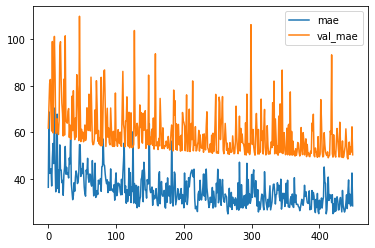

In [109]:
df_history = pd.DataFrame({"mae" : history.history["mae"][50:], "val_mae" : history.history["val_mae"][50:]})
df_history.plot()

In [61]:
preds = model.predict(x_test)
test_results = []
for idx, pred in enumerate(preds):
    this_label = y_test[idx]
    test_results.append({"label" : this_label, "predict" : pred[0], "error" : this_label - pred[0]})

test_results = pd.DataFrame(test_results)
test_results

,label,predict,error
0,0.525160,0.435553,0.089607
1,0.533641,0.433613,0.100029
2,0.529495,0.463380,0.066116
3,0.513393,0.470789,0.042605
4,0.516765,0.433442,0.083323
...,...,...,...
379,0.703632,0.398200,0.305433
380,0.693998,0.441169,0.252829
381,0.703768,0.443785,0.259982
382,0.704471,0.458427,0.246044
